In [68]:
#multi channel CNN for sentiment analysis
from nltk.corpus import stopwords
from string import punctuation
from os import listdir
from pickle import dump,load
import pandas as pd
import numpy as np
import re
from random import shuffle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [69]:
#loading data
def load_file_to_df(filename):
    df = pd.read_csv(filename,delimiter='\t',header=0)
    df = df.drop(['Unnamed: 0', 'id'],axis=1)
    df_text = df.iloc[:,:1]
    df_score = df.iloc[:,1:]
    return df_text,df_score

In [70]:
headlines_text,headlines_score = load_file_to_df("FiQA_train_ABSA_financial_headlines.tsv")
post_text,post_score = load_file_to_df("FiQA_train_ABSA_financial_posts.tsv")
text = pd.concat([headlines_text,post_text])
score = pd.concat([headlines_score,post_score])

In [71]:
# score

In [72]:
# turn a sentence into clean tokens
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [73]:
# extract sentences out of df and cleaning it
sentences = [clean_sentence(x) for x in text['text']]

In [74]:
#converting real number scores to lables
#0-->-ve sentiment 1-->+ve sentiment
labels_df = (score>=0).astype(int)
labels = [int(x) for x in labels_df['sentiment score']]

In [75]:
#shuffling dataset
numbers = [i for i in range(len(sentences))]
shuffle(numbers)
# numbers

In [76]:
temp_text = sentences
temp_lables = labels
for i in numbers:
    sentences[i] = temp_text[i]
    labels[i]=temp_lables[i]
print(len(sentences))
print(len(labels))

3789
3789


In [77]:
#doing train and test split
test_train_split_ratio =0.9
trainX,testX = sentences[:int(test_train_split_ratio*len(sentences))],sentences[int(test_train_split_ratio*len(sentences)):]
trainY,testY = labels[:int(test_train_split_ratio*len(labels))],labels[int(test_train_split_ratio*len(labels)):]

In [78]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

3410 3410
379 379


In [79]:
# type(trainY[0])

In [80]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [81]:
# calculate the maximum document length
# def max_length(lines):
#     return max([len(s.split()) for s in lines])

In [82]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [83]:
testLines = [' '.join(x) for x in testX]
trainLines = [' '.join(x) for x in trainX]

In [84]:
# trainY = np.array(trainY)
# testY = np.array(testY)
# type(trainY[0])

In [85]:
# create tokenizer
tokenizer = create_tokenizer(trainLines)
# calculate max document length
lengths = [len(s.split()) for s in trainLines]
length = max(lengths)
# length = max_length(trainLines)
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainLines, length)
print(trainX.shape)

Max document length: 21
Vocabulary size: 6019
(3410, 21)


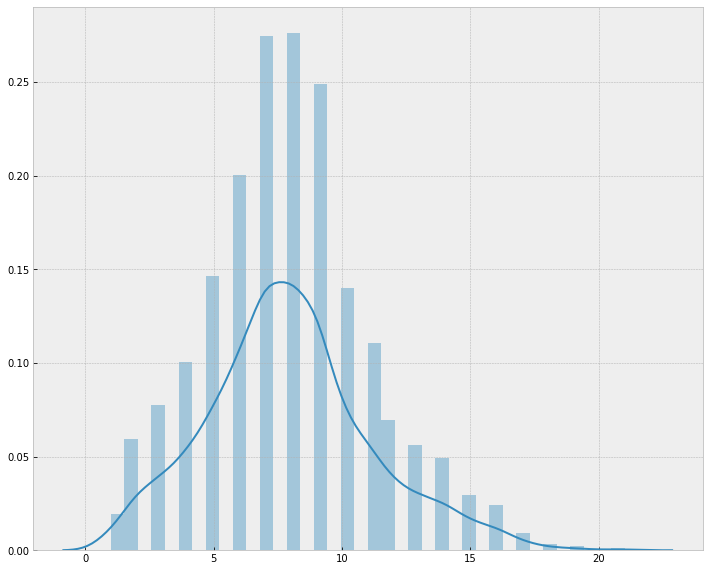

In [89]:
plt.subplots(figsize=(12,10))
sns.distplot(lengths)
# plt.hist(lengths, normed=True,edgecolor='black')

In [90]:
# define the model
def define_model(length, vocab_size):
    # channel 1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size, 100)(inputs1)
    conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # channel 2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size, 100)(inputs2)
    conv2 = Conv1D(filters=32, kernel_size=6, activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # channel 3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size, 100)(inputs3)
    conv3 = Conv1D(filters=32, kernel_size=8, activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize
    print(model.summary())
#     plot_model(model, show_shapes=True, to_file='multichannel.png')
    return model

In [91]:
# define model
model = define_model(length, vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 21)           0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 21, 100)      601900      input_13[0][0]                   
__________________________________________________________________________________________________
embedding_

In [92]:
# fit model
history_object = model.fit([trainX,trainX,trainX], trainY, epochs=10, batch_size=16)

Epoch 1/10
3410/3410 [==============================] - 6s 2ms/step - loss: 0.6175 - acc: 0.6449
Epoch 2/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.2824 - acc: 0.8909
Epoch 3/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.1157 - acc: 0.9598
Epoch 4/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0749 - acc: 0.9762
Epoch 5/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0605 - acc: 0.9736
Epoch 6/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0517 - acc: 0.9745
Epoch 7/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0444 - acc: 0.9742
Epoch 8/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0419 - acc: 0.9748
Epoch 9/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0372 - acc: 0.9780
Epoch 10/10
3410/3410 [==============================] - 5s 2ms/step - loss: 0.0378 - acc: 0.9739


In [94]:
history_object.history

{'acc': [0.6448680351906159,
  0.8909090909090909,
  0.9598240469208211,
  0.9762463343108504,
  0.9736070381231672,
  0.9744868035190616,
  0.9741935483870968,
  0.9747800586510263,
  0.9780058651026393,
  0.9739002932551319],
 'loss': [0.6175432717695264,
  0.28238428257777193,
  0.11574882219362556,
  0.07492264324411356,
  0.060477080547368244,
  0.051697185935993345,
  0.044384930458034544,
  0.04193199218299972,
  0.03722214455195857,
  0.037796619572592054]}

In [95]:
#testing
# encode data
# trainX = encode_text(tokenizer, trainLines, length)
testX = encode_text(tokenizer, testLines, length)
print(trainX.shape, testX.shape)

(3410, 21) (379, 21)


In [96]:
# evaluate model on training dataset
loss, acc = model.evaluate([trainX,trainX,trainX], trainY, verbose=0)
print('Train Accuracy: %f' % (acc*100))
 
# evaluate model on test dataset dataset
loss, acc = model.evaluate([testX,testX,testX], testY, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Train Accuracy: 98.240469
Test Accuracy: 81.794195


In [97]:
predicted_prob = [float(x) for x in model.predict([testX,testX,testX])]
predicted_prob

[0.984401285648346,
 0.2861824631690979,
 0.8282769322395325,
 0.1894727647304535,
 0.0016269393963739276,
 0.11385886371135712,
 0.9967464208602905,
 0.9991810917854309,
 0.8246086239814758,
 0.9862838983535767,
 0.9949827194213867,
 0.9998772144317627,
 0.16365066170692444,
 0.9683470129966736,
 0.7048979997634888,
 0.5394086837768555,
 0.968193531036377,
 0.9980948567390442,
 0.9981735944747925,
 0.9949514865875244,
 0.9868404865264893,
 0.6714014410972595,
 0.9742463827133179,
 0.6775494813919067,
 0.9185274243354797,
 0.9556636214256287,
 0.8251076340675354,
 0.9988013505935669,
 0.9979191422462463,
 0.6555987596511841,
 0.9222675561904907,
 0.5982614755630493,
 0.9817230105400085,
 0.970436692237854,
 0.49146968126296997,
 0.9753916263580322,
 0.5249939560890198,
 0.0010333689860999584,
 0.9922467470169067,
 0.4263550341129303,
 0.9049941301345825,
 0.9381777048110962,
 0.3361285328865051,
 0.2175980806350708,
 0.9905635118484497,
 0.3338456153869629,
 0.9979845285415649,
 0.9627

In [98]:
predicted_lables = []
for x in predicted_prob:
    if x>0.5:
        predicted_lables.append(1)
    else:
        predicted_lables.append(0)
predicted_lables

[1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [99]:
testY

[1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
